# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

### Importing Libraries

In [314]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

#imports to help me plot my venn diagrams
import matplotlib_venn as venn2
from matplotlib_venn import venn2
from pylab import rcParams

# import the util.py file where I define my functions
from utils import *

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, Imputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as gbm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve

import xgboost as xgb
import lightgbm as lgb

import time
from timeit import default_timer as timer

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [89]:
# load in the data
'''
DtypeWarning: Columns (19,20) have mixed types.
The warnings will be addressed in the pre-processing steps
'''
azdias = pd.read_csv('azdias.csv', index_col=0)
azdias.reset_index(drop=True, inplace=True)
customers = pd.read_csv('customers.csv', index_col=0)
customers.reset_index(drop=True, inplace=True)
feat_info = pd.read_csv("feature_summary_complete.csv", sep= ',')
dias = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header = 1)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


To know the missing or unknown values dias will be used, making row 1 as header and deleting unnamed columns.

In [90]:
dias.drop(columns=['Unnamed: 0'], inplace=True)
dias['Attribute'] = dias['Attribute'].ffill()
dias.head()


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


In [91]:
# Investigating column 19 and 20.
print(azdias.iloc[:,19:21].columns)
print(customers.iloc[:,19:21].columns)

Index(['CAMEO_INTL_2015', 'CJT_GESAMTTYP'], dtype='object')
Index(['CAMEO_INTL_2015', 'CJT_GESAMTTYP'], dtype='object')



These columns are reason for mixed type warnings due to X in the columns.

In [92]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [93]:
azdias = special_feature_handler(azdias)
customers = special_feature_handler(customers)

In [94]:
#doing a quick check of categorical features and see if some are too granular to be maintained
cat_check = categorical_checker(azdias, feat_info)

AGER_TYP                        5
ANREDE_KZ                       2
CJT_GESAMTTYP                   6
FINANZTYP                       6
GFK_URLAUBERTYP                12
GREEN_AVANTGARDE                2
LP_FAMILIE_FEIN                12
LP_FAMILIE_GROB                 6
LP_STATUS_FEIN                 10
LP_STATUS_GROB                  5
NATIONALITAET_KZ                4
SHOPPER_TYP                     5
SOHO_KZ                         2
TITEL_KZ                        6
VERS_TYP                        3
ZABEOTYP                        6
KK_KUNDENTYP                    6
D19_KONSUMTYP                   7
D19_GESAMT_ANZ_12               7
D19_GESAMT_ANZ_24               7
D19_BANKEN_ANZ_12               7
D19_BANKEN_ANZ_24               7
D19_GESAMT_OFFLINE_DATUM       10
D19_GESAMT_ONLINE_DATUM        10
D19_GESAMT_DATUM               10
D19_BANKEN_OFFLINE_DATUM       10
D19_BANKEN_ONLINE_DATUM        10
D19_BANKEN_DATUM               10
D19_TELKO_OFFLINE_DATUM        10
D19_TELKO_ONLI


The above information hints at CAMEO_DEU_2015 being too fragmented with 45 category values and a makes a good case to drop this column.
Columns 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP' are not identical between two datasets, hence dropping these to maintain homogeneity.

In [95]:
customers = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=False, axis=1)

#### Checking shapes of datasets

#### Azdias Shape

In [96]:
# checking how the azdias dataframe looks like
print('Printing dataframe shape')
print(azdias.shape)
print('________________________________________________________')

azdias.head()

Printing dataframe shape
(891221, 366)
________________________________________________________


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


#### Customers Shape

In [97]:
# checking how the customer dataframe looks like
print('Printing dataframe shape')
print(customers.shape)
print('________________________________________________________')

customers.head()

Printing dataframe shape
(191652, 366)
________________________________________________________


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


#### feat_info shape

In [98]:
# Check the summary csv file
print(feat_info.shape)
feat_info.head()

(324, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


#### We can see azdias and customers have similar number of columns now
#### azdias: (891221, 366)  customers: (191652, 366)

## Preprocessing
Here I will investigate and deal with missing values, re-encode features, feature engineering and feature scaling

In [99]:
azdias_pre_cleanup = azdias.copy()
customers_pre_cleanup = customers.copy()

In [100]:
unknowns_to_NANs(azdias, dias)

In [101]:
unknowns_to_NANs(customers, dias)

I am going to drop columns of missing data over a a threshold, I need to check the columns between azdias and customers on processed data. To start with I am defining threshold as 30%.

In [102]:
balance_checker(azdias, customers)

Feature balance between dfs?:  True


#### Match azdias and customers before cleanup

In [103]:
percent_missing_azdias_df = percentage_of_missing(azdias)
percent_missing_azdias_pc_df = percentage_of_missing(azdias_pre_cleanup)

percent_missing_customers_df = percentage_of_missing(customers)
percent_missing_customers_pc_df = percentage_of_missing(customers_pre_cleanup)

In [104]:
print('Identified missing data in Azdias: ')
print('Pre-cleanup: ' + str(azdias_pre_cleanup.isnull().sum().sum()) + 
      ' Post_cleanup: ' + str(azdias.isnull().sum().sum()))

print('Identified missing data in Customers: ')
print('Pre-cleanup: ' + str(customers_pre_cleanup.isnull().sum().sum()) +
      ' Post_cleanup: ' + str(customers.isnull().sum().sum()))

Identified missing data in Azdias: 
Pre-cleanup: 33493669 Post_cleanup: 37088263
Identified missing data in Customers: 
Pre-cleanup: 13864774 Post_cleanup: 14488721


In [105]:
print('Azdias columns not missing values(percentage):')
print('Pre-cleanup: ', (percent_missing_azdias_df['percent_missing'] == 0.0).sum())
print('Post-cleanup: ', (percent_missing_azdias_pc_df['percent_missing'] == 0.0).sum())

print('Customers columns not missing values(percentage):')
print('Pre-cleanup: ', (percent_missing_customers_df['percent_missing'] == 0.0).sum())
print('Post-cleanup: ', (percent_missing_customers_pc_df['percent_missing'] == 0.0).sum())

Azdias columns not missing values(percentage):
Pre-cleanup:  87
Post-cleanup:  93
Customers columns not missing values(percentage):
Pre-cleanup:  87
Post-cleanup:  93


#### Defining the threshold to decide what can to go

In [106]:
# missing more or less than 30% of the data
azdias_missing_over_30 = split_on_percentage(percent_missing_azdias_df, 30, '>')
azdias_missing_less_30 = split_on_percentage(percent_missing_azdias_df, 30, '<=')

customers_missing_over_30 = split_on_percentage(percent_missing_customers_df, 30, '>')
customers_missing_less_30 = split_on_percentage(percent_missing_customers_df, 30, '<=')

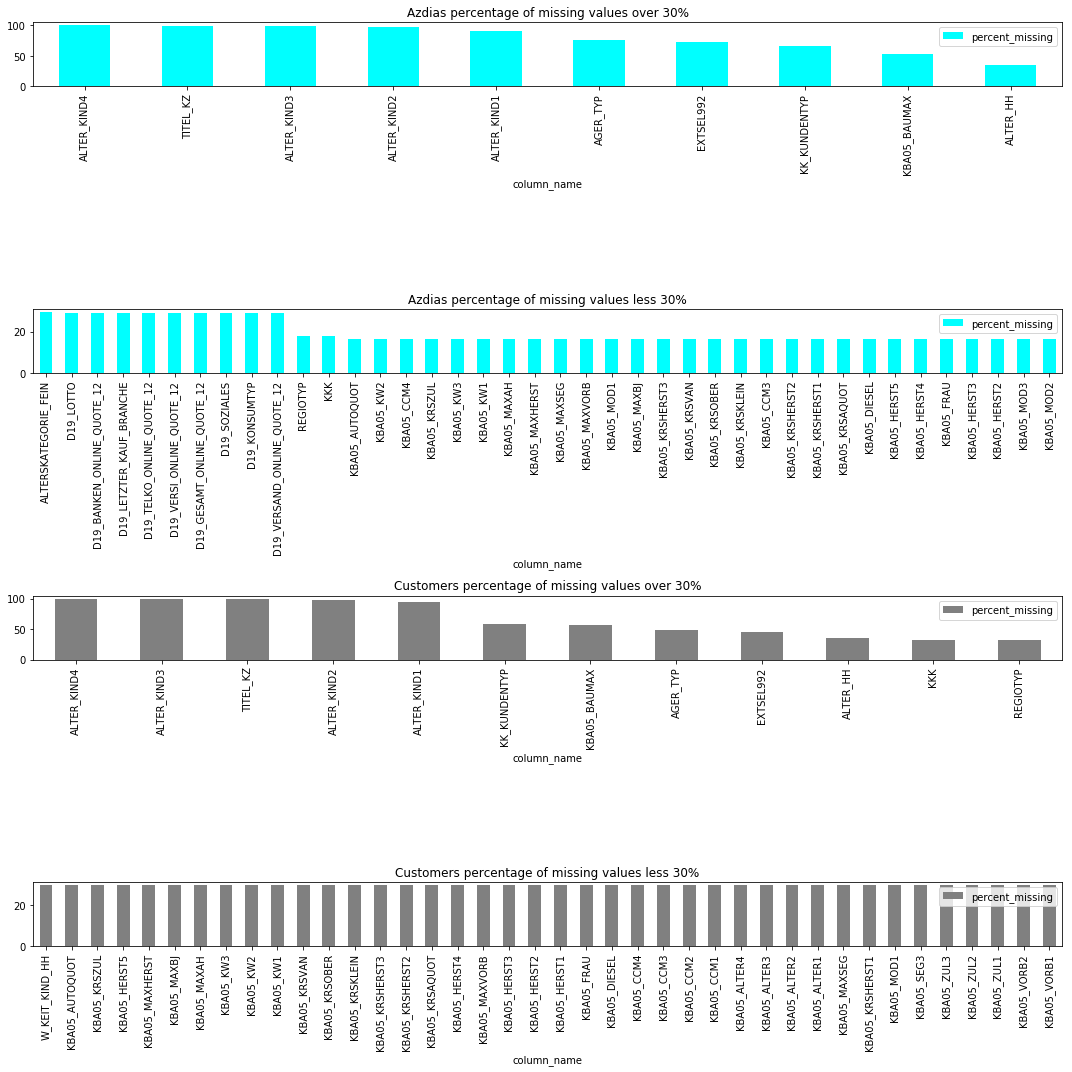

In [107]:
#plotting select features and their missing data percentages
figure, axes = plt.subplots(4, 1, figsize = (15,15), squeeze = False)

azdias_missing_over_30.sort_values(by = 'percent_missing', ascending = False).plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[0][0], color = 'cyan', title = 'Azdias percentage of missing values over 30%' )

#due to the sheer amount of data points to be plotted this does not make an appealing vis so I will restrict
#the number of plotted points to 40
azdias_missing_less_30.sort_values(by = 'percent_missing', ascending = False)[:40].plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[1][0], color = 'cyan', title = 'Azdias percentage of missing values less 30%' )

customers_missing_over_30.sort_values(by = 'percent_missing', ascending = False).plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[2][0], color = 'grey', title = 'Customers percentage of missing values over 30%' )

#due to the sheer amount of data points to be plotted this does not make an appealing vis so I will restrict
#the number of plotted points to 40
customers_missing_less_30.sort_values(by = 'percent_missing', ascending = False)[:40].plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[3][0],color = 'grey', title = 'Customers percentage of missing values less 30%' )

plt.tight_layout()
plt.show()

### I will be taking out columns which are missing data over 30 % as majority of the columns have missing data less than 30%

In [108]:
#extracting column names with more than 30% values missing so we can drop them from azdias df
azdias_col_delete = columns_to_delete(azdias_missing_over_30)

#extracting column names with more than 30% values missing so we can drop them from customers df
customers_col_delete = columns_to_delete(customers_missing_over_30)

In [109]:
#dropping the columns identified in the previous lists

azdias = azdias.drop(azdias_col_delete, axis = 1)
customers = customers.drop(customers_col_delete, axis = 1)

In [110]:
#since I just dropped several columns I will do another balance check
balance_checker(azdias, customers)

Feature balance between dfs?:  False
Your first argument df differs from the second on the following columns: 
{'KKK', 'REGIOTYP'}
Your second argument df differs from the first on the following columns: 
set()


### Lets check if its beneficial to drop rows which are of less significance in our analysis

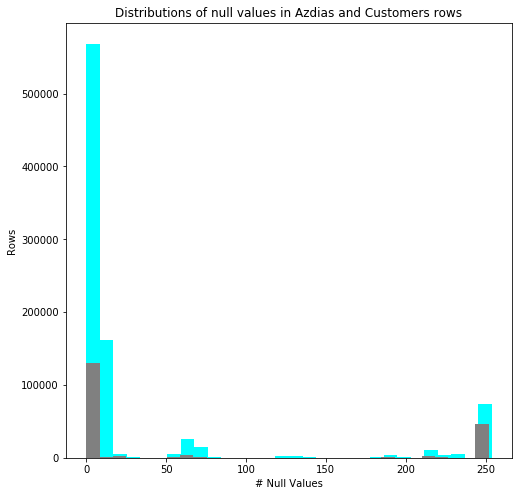

In [58]:
#plotting distribution of null values
row_hist(azdias, customers, 30)

#### The above visualization shows us that majority of rows have less than 100 missing values and we can see the rows of two datasets overlapping indicating both are missing same info


#deleting rows based on the above info
#azdias = row_dropper(azdias, 100)
#customers = row_dropper(customers, 100)

#plotting null values distribution after cleanup
#row_hist(azdias, customers, 30)

In [111]:
balance_checker(azdias, customers)

Feature balance between dfs?:  False
Your first argument df differs from the second on the following columns: 
{'KKK', 'REGIOTYP'}
Your second argument df differs from the first on the following columns: 
set()


#### Its a good idea not to drop rows as it worsens the clustering performance

## Feature Encoding

### There are many features we have to re-encode to proceed with the Unsupervised learning portion

I will be re-encoding Categorical features and mixed type features.

In [112]:
#checking for mixed type features
feat_info[feat_info.type == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
89,WOHNLAGE,building,mixed,[-1]
92,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
103,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
318,PLZ8_BAUMAX,plz8,mixed,"[-1,0]"


In [113]:
#retrieve a list of categorical features for future encoding
cats = feat_info[feat_info.type == 'categorical']
list(cats['attribute'])

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'D19_KONSUMTYP',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_TELKO_ ANZ_12',
 'D19_TELKO_ ANZ_24',
 'D19_VERSI_ ANZ_12 ',
 'D19_VERSI_ ANZ_24',
 'D19_VERSAND_ ANZ_12 ',
 'D19_VERSAND_ ANZ_24',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_TELKO_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'D19_VERSI_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_VERSAND_ONLINE_QUO

In the CAMEO_INTL_2015 column I have converted XX to nan

PRAEGENDE_JUGENDJAHRE has 3 dimensions: generation decade, mainstream or avant-garde and east or west, hence I will create new features out of this particular column.

LP_LEBENSPHASE_GROB seems to encode the same information as the CAMEO column and it is divided between gross(grob) and fine (fein) 

In [114]:
balance_checker(azdias, customers)

Feature balance between dfs?:  False
Your first argument df differs from the second on the following columns: 
{'KKK', 'REGIOTYP'}
Your second argument df differs from the first on the following columns: 
set()


## Feature engineering
#### Based on the previous exploration there are a few features that are good candidates for novel feature creation

In [115]:
azdias_eng = azdias.copy()
customers_eng = customers.copy()
azdias_eng = feat_eng(azdias_eng)
customers_eng = feat_eng(customers_eng)

Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
Creating WOHNLAGE_QUALITY feature
Creating WOHNLAGE_AREA feature
Creating Wealth and Family feature
Creating LP_LEBENSPHASE_FEIN_life_stage and LP_LEBENSPHASE_FEIN_fine_scale feature
Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
Creating WOHNLAGE_QUALITY feature
Creating WOHNLAGE_AREA feature
Creating Wealth and Family feature
Creating LP_LEBENSPHASE_FEIN_life_stage and LP_LEBENSPHASE_FEIN_fine_scale feature


balance_checker(azdias, customers)

## Feature scaling
### I will be performing feature scaling to have continuous features in identical scales


In [169]:
#dataframes using StandardScaler
azdias_SS = feature_scaling(azdias_eng, 'StandardScaler')
customers_SS = feature_scaling(customers_eng, 'StandardScaler')

In [170]:
#dataframes using MinMaxScaler
azdias_MMS = feature_scaling(azdias_eng, 'MinMaxScaler')
customers_MMS = feature_scaling(customers_eng, 'MinMaxScaler')

## Dimensionality Reduction
### I will use PCA to consider only most impacting features which helps in identifying patterns and reduce complexity of further analysis

In [118]:
n_components_azdias = len(azdias_SS.columns.values)
n_components_customers = len(customers_SS.columns.values)

azdias_SS_pca = pca_model(azdias_SS, n_components_azdias)
customers_SS_pca = pca_model(customers_SS, n_components_customers)

azdias_MMS_pca = pca_model(azdias_MMS, n_components_azdias)
customers_MMS_pca = pca_model(customers_MMS, n_components_customers)

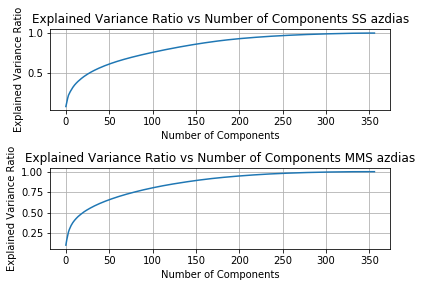

In [119]:
scree_plots(azdias_SS_pca, azdias_MMS_pca, ' azdias')

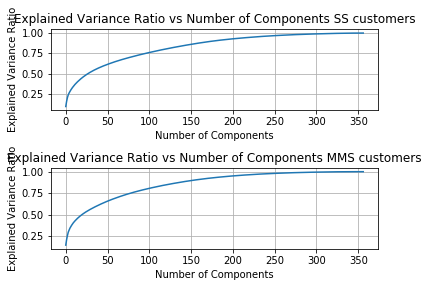

In [120]:
scree_plots(customers_SS_pca, customers_MMS_pca, ' customers')

Each principal component is a directional vector pointing to the highest variance. The greater the distance from 0 the more the vector points to a feature.

Lets check some interesting features in up to the third dimension.

In [121]:
display_interesting_features(azdias_SS, azdias_SS_pca, 0)

Lowest: 
	CAMEO_DEUG_2015      -0.126
	KBA13_ANTG3          -0.124
	PLZ8_ANTG3           -0.124
Highest: 
	MOBI_RASTER          0.124
	KBA13_ANTG1          0.124
	PLZ8_ANTG1           0.125


In [122]:
display_interesting_features(azdias_SS, azdias_SS_pca, 1)

Lowest: 
	D19_GESAMT_ONLINE_DATUM -0.143
	D19_GESAMT_DATUM     -0.140
	D19_VERSAND_ONLINE_DATUM -0.138
Highest: 
	D19_GESAMT_ANZ_12    0.139
	ONLINE_AFFINITAET    0.140
	D19_GESAMT_ANZ_24    0.147


In [123]:
display_interesting_features(azdias_SS, azdias_SS_pca, 3)

Lowest: 
	PRAEGENDE_JUGENDJAHRE_DECADE -0.196
	FINANZ_UNAUFFAELLIGER -0.191
	FINANZ_SPARER        -0.191
Highest: 
	LP_LEBENSPHASE_FEIN_life_stage 0.147
	ALTERSKATEGORIE_GROB 0.160
	FINANZ_VORSORGER     0.168


#### Lets have a look at the most important features: 
- dimension 1(0) using standard scaler:

    These are some of features related to positive weights considering positive relationship:
    
    - MOBI_RASTER: refers to the individual's mobility
    - KBA13_ANTG1: lower share of car owners
    - PLZ8_ANTG1 : lower number of 1-2 family houses
    
    And these are some of the feaures related to negative weights considering negative relationship:
    
    - KBA13_ANTG4: refers to posession of higher number of cars
    - PLZ-ANTG3: number of 6-10 family houses in the PLZ8
    - CAMEO_DEU_2015: detailed classification os cultural and living status 
    
The first dimension refers to the social status and living conditions of the individuals.


#### Based on these plots:
- using standard scaler with 150 principal components 90% of the original variance can be represented
- using minmax scaler with 150 components we represent 90% of the original variance

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Let start with Kmeans to find relevant clusters

####  I need to decide on number of clusters for Kmeans

In [175]:
azdias_SS1 = azdias_SS
azdias_MMS1 = azdias_MMS

In [176]:
pca = PCA(150)
azdias_SS_pca1 = pca.fit_transform(azdias_SS1)
azdias_MMS_PCA1 = pca.fit_transform(azdias_MMS1)

In [186]:
pca = PCA(150)
azdias_SS_pca = pca.fit_transform(azdias_SS)
customers_SS_PCA = pca.fit_transform(customers_SS)

The elbow method (https://bl.ocks.org/rpgove/0060ff3b656618e9136b) is a way to validate the optimal number of clusters to use for a particular dataset.
It can take some time training the dataset, optimising for the optimal n of clusters means that less resources are used.

Based on the elbow plot 9 clusters should be enough to proceed with the kmeans training

In [177]:
def elbow_method(data):
    scores = []
    centers = list(range(1,20))
    i = 0
    for center in centers:
        i += 1
        print(i)
        scores.append(fit_kmeans(data, center))
        
    # Investigate the change in within-cluster distance across number of clusters.
    # Plot the original data with clusters
    plt.plot(centers, scores, linestyle='--', marker='o', color='b')
    plt.ylabel('SSE score')
    plt.xlabel('K')
    plt.title('SSE vs K')

    #Using a regression to determine where it is a good cluster number to divide the population (when the gradient decreases)
    l_reg = LinearRegression()
    l_reg.fit(X=np.asarray([[9,10,11,12,13,14]]).reshape(6,1), y=scores[8:14])
    predicted =l_reg.predict(np.asarray(range(2,9)).reshape(-1,1))
    plt.plot(list(range(2,20)),np.asarray(list(predicted.reshape(-1,1)) + list(scores[8:20])),'r')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
CPU times: user 3h 44min 46s, sys: 24min 15s, total: 4h 9min 1s
Wall time: 2h 46min 58s


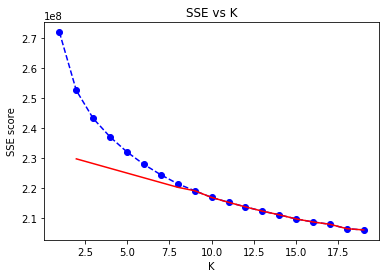

In [179]:
%%time
elbow_method(azdias_SS_pca1)

In [ ]:
%%time
elbow_method(azdias_pca_MMS)

In [279]:
# refitting using just 9 clusters
kmeans = KMeans(9)
kmodel = kmeans.fit(azdias_SS_pca)

In [280]:
#and now we can compare the customer data to the general demographics
azdias_clusters = kmodel.predict(pca.transform(azdias_SS))
customers_clusters = kmodel.predict(pca.transform(customers_SS))

In [281]:
#getting clusters for the LNRs for the customers
cluster_map = pd.DataFrame()
cluster_map['LNR'] = azdias_eng.index.values
cluster_map['cluster'] = kmodel.labels_

#### Experimenting with visualization of the clusters

In [318]:
#preparing cluster visualization
from collections import Counter

azdias_labels = kmeans.labels_
customers_labels = kmeans.labels_

model_feat = list(azdias_eng.columns)
cust_feat = list(customers_eng.columns)

model_feat_df = pd.DataFrame()
model_feat_df['model_feat'] = model_feat

#Find model features not in customer features
model_feat_notin_cust = [feat for feat in model_feat if feat not in cust_feat]
len(model_feat_notin_cust)


customers_pca = pca.transform(customers_eng)
customers_labels = kmeans.predict(customers_pca)

counts_customer = Counter(customers_labels)
n_customers = customers_pca.shape[0]

customer_freqs = {label: 100*(freq / n_customers) for label, freq in counts_customer.items()}

counts_population = Counter(azdias_labels)
n_population = azdias_SS_pca.shape[0]

population_freqs = {label: 100*(freq / n_population) for label, freq in counts_population.items()}


customer_clusters = pd.DataFrame.from_dict(customer_freqs, orient='index', columns=['% of data'])
customer_clusters['Cluster'] = customer_clusters.index
customer_clusters['DataSet'] = 'Customers Data'
population_clusters = pd.DataFrame.from_dict(population_freqs, orient='index', columns=['% of data'])
population_clusters['Cluster'] = population_clusters.index
population_clusters['DataSet'] = 'General Population'

all_clusters = pd.concat([customer_clusters, population_clusters])
all_clusters

,% of data,Cluster,DataSet
7,21.391898,7,Customers Data
4,78.584622,4,Customers Data
3,0.023480,3,Customers Data
6,8.846852,6,General Population
3,13.874561,3,General Population
1,13.862779,1,General Population
2,8.177994,2,General Population
7,8.981835,7,General Population
8,12.629527,8,General Population
4,14.268627,4,General Population


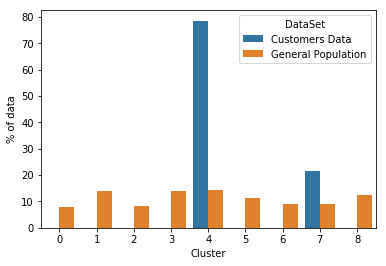

In [319]:
sns.barplot(x='Cluster', y='% of data', hue='DataSet', data=all_clusters)
plt.show()

In [283]:
#transform the customers using pca
customers_pca = pca.transform(customers_SS)

#predict clustering using the kmeans
predict_customers = kmodel.predict(customers_pca)

#cluster and center prediction and info
clust_preds = kmodel.predict(azdias_SS_pca)
centers = kmodel.cluster_centers_


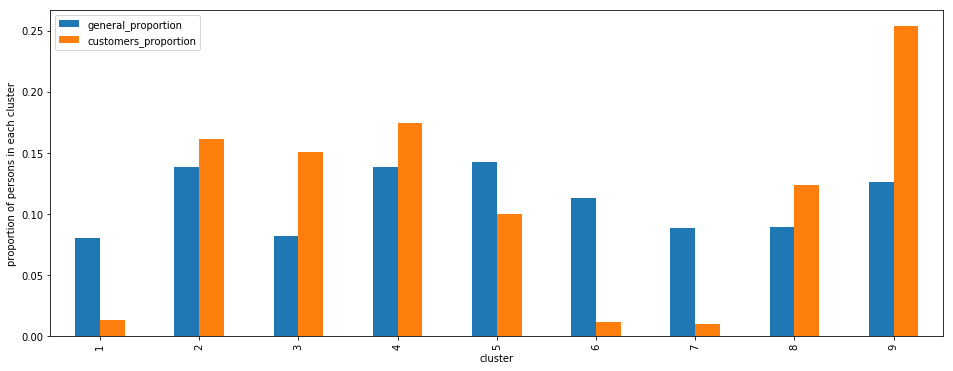

In [284]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_pop = []
customers_pop = []
x = [i+1 for i in range(9)]
for i in range(9):
    general_pop.append((clust_preds == i).sum()/len(clust_preds))
    customers_pop.append((predict_customers == i).sum()/len(predict_customers))


df_general = pd.DataFrame({'cluster' : x, 'general_proportion' : general_pop, 'customers_proportion':customers_pop})

df_general.plot(x='cluster', y = ['general_proportion', 'customers_proportion'], kind='bar', figsize=(16,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [285]:
mailout_train = pd.read_csv("mailout_train.csv")
mailout_test = pd.read_csv("mailout_test.csv")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [286]:
#running all the cleaning and feature transformation functions
#fixing the mixed type columns
mailout_train = special_feature_handler(mailout_train)
mailout_test = special_feature_handler(mailout_test)

#dealing with missing and unknowns
unknowns_to_NANs(mailout_train, dias)
unknowns_to_NANs(mailout_test, dias)

#getting percentages of missing
percent_missing_train = percentage_of_missing(mailout_train)
percent_missing_test = percentage_of_missing(mailout_test)

#getting missing over 30%
train_missing_over_30 = split_on_percentage(percent_missing_train, 30, '>')
test_missing_over_30 = split_on_percentage(percent_missing_test, 30, '>')

#getting columns to delete
train_col_delete = columns_to_delete(train_missing_over_30)
test_col_delete = columns_to_delete(test_missing_over_30)

#dropping cols
mailout_train = mailout_train.drop(train_col_delete, axis = 1)
mailout_test = mailout_test.drop(test_col_delete, axis = 1)

#feature engineering
mailout_train = feat_eng(mailout_train)
mailout_test = feat_eng(mailout_test)

Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
Creating WOHNLAGE_QUALITY feature
Creating WOHNLAGE_AREA feature
Creating Wealth and Family feature
Creating LP_LEBENSPHASE_FEIN_life_stage and LP_LEBENSPHASE_FEIN_fine_scale feature
Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
Creating WOHNLAGE_QUALITY feature
Creating WOHNLAGE_AREA feature
Creating Wealth and Family feature
Creating LP_LEBENSPHASE_FEIN_life_stage and LP_LEBENSPHASE_FEIN_fine_scale feature


In [287]:
mailout_train.to_csv('mailout_train_clean.csv')
mailout_test.to_csv('mailout_test_clean.csv')

#since I just dropped several columns I will do another balance check

In [288]:
balance_checker(azdias_eng, mailout_train)

Feature balance between dfs?:  False
Your first argument df differs from the second on the following columns: 
set()
Your second argument df differs from the first on the following columns: 
{'RESPONSE'}


In [289]:
balance_checker(mailout_train, mailout_test)

Feature balance between dfs?:  False
Your first argument df differs from the second on the following columns: 
{'RESPONSE'}
Your second argument df differs from the first on the following columns: 
set()


#### Before moving on to the model I want to experiment a bit with the identified clusters and how the responses align with the clusters

In [290]:
#merging mailout and cluster map on the LNR column
clusters_mailout = pd.merge(mailout_train, cluster_map, on = 'LNR')
response_and_cluster = clusters_mailout[['LNR', 'RESPONSE', 'cluster']]

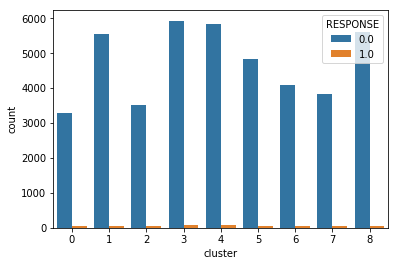

In [291]:
ax = sns.countplot(x="cluster", hue="RESPONSE", data=response_and_cluster)

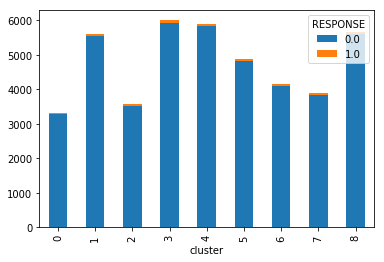

In [292]:
plot1 = response_and_cluster.groupby(['cluster', 'RESPONSE'])['RESPONSE'].count().unstack('RESPONSE')
plot1[[0, 1]].plot(kind = 'bar', stacked = True)

In [293]:
df_pos_response = response_and_cluster[response_and_cluster['RESPONSE'] == 1]
df_neg_response = response_and_cluster[response_and_cluster['RESPONSE'] == 0]

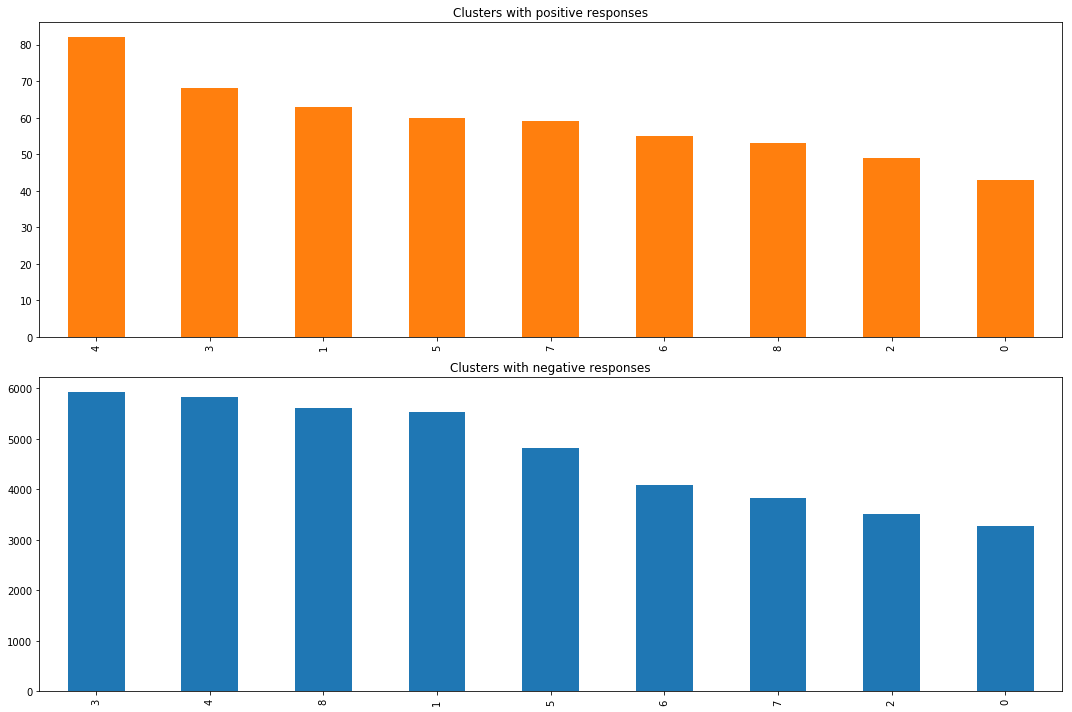

In [294]:
figure, axes = plt.subplots(2, 1, figsize = (15,15), squeeze = False)

pos = df_pos_response['cluster'].value_counts().plot(kind='bar',figsize=(15,10), color = 'C1', ax = axes[0][0], title = 'Clusters with positive responses')
neg = df_neg_response['cluster'].value_counts().plot(kind='bar',figsize=(15,10), ax = axes[1][0], title = 'Clusters with negative responses')

plt.tight_layout()
plt.show()


### Getting to the models for response prediction

In [295]:
#getting the target
target = mailout_train['RESPONSE']
mailout_train_clean = mailout_train.drop(['RESPONSE'], inplace=False, axis=1)

In [296]:
#dropping LNR
mailout_test_clean = mailout_test.copy()
mailout_train_clean.drop(['LNR'], inplace = True, axis = 1)
mailout_test_clean.drop(['LNR'], inplace = True, axis = 1)

In [297]:
balance_checker(mailout_train_clean, mailout_test_clean)

Feature balance between dfs?:  True


Text(0.5, 1.0, 'Label distribution')

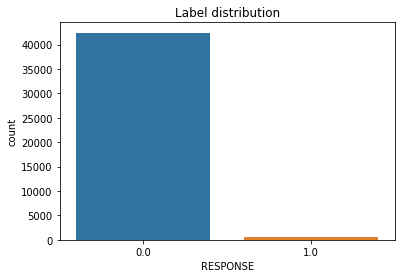

In [298]:
#checking the label distribution

sns.countplot(target).set_title("Label distribution")

Based on this plot these datasets are quite imbalanced, there are quite a few more responses corresponding to 0 than to 1.

Considering this accuracy will not be an appropriate metric, ROC-AUC is a better option (1 being a perfect score, and 0.5 just random chance)

Lets try model selection

In [299]:
SEED = 28

In [300]:
# 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
skf.get_n_splits(mailout_train_clean, target)

5

The best performing model seem to be XGB so from here on I will continue the analysis with this model.
There also seems to be no difference beetween standard scaler and Min Max Scaler. since the second is a bit faster I will stick with it.

In [301]:
scaler = MinMaxScaler()
scaler.fit(mailout_train_clean.astype('float'))

mailout_train_scaled = scaler.transform(mailout_train_clean)
mailout_test_scaled = scaler.transform(mailout_test_clean)

# map back to dfs
mailout_train_scaled = pd.DataFrame(data=mailout_train_scaled, columns=mailout_train_clean.columns)
mailout_test_scaled = pd.DataFrame(data=mailout_test_scaled, columns=mailout_test_clean.columns)

In [302]:
balance_checker(mailout_train, mailout_test)

Feature balance between dfs?:  False
Your first argument df differs from the second on the following columns: 
{'RESPONSE'}
Your second argument df differs from the first on the following columns: 
set()


### I experimented with multiple models to determine which one was the best performing.
### The best performer was xgboost so I decided to use the Bayesian Optimization algorithm to fine tune the hyperparameters that produce the best results.

In [303]:
#submission 1 parameters
bayes_xgb = xgb.XGBClassifier(base_score=0.5, 
                              booster='gbtree', 
                              colsample_bylevel=1,
                              colsample_bytree=0.6872852588903648, 
                              eval_metric='auc', 
                              gamma=1.0,
                              learning_rate=0.014017007043823785, 
                              max_delta_step=0, 
                              max_depth=7,
                              min_child_weight=1, 
                              missing=None, 
                              n_estimators=236, 
                              n_jobs=-1,
                              nthread=None, 
                              objective='binary:logistic', 
                              random_state=0,
                              reg_alpha=1e-09, 
                              reg_lambda=1, 
                              scale_pos_weight=1, 
                              seed=None,
                              silent=1, 
                              subsample=0.5)



#submission 2 parameters
bayes_xgb = xgb.XGBClassifier(base_score=0.5, 
                              booster='gbtree', 
                              colsample_bylevel=1,
                              colsample_bytree=1, 
                              eval_metric='auc', 
                              gamma=0,
                              learning_rate=0.04788137748021131, 
                              max_delta_step=0, 
                              max_depth=1,
                              min_child_weight=10, 
                              missing=None, 
                              n_estimators=429, 
                              n_jobs=-1,
                              nthread=None, 
                              objective='binary:logistic', 
                              random_state=0,
                              reg_alpha=0.17651703245342792, 
                              reg_lambda=1, 
                              scale_pos_weight=1, 
                              seed=None,
                              silent=1, 
                              subsample=0.5)

#submission 3 parameters
bayes_xgb = xgb.XGBClassifier(base_score=0.5, 
                              booster='gbtree', 
                              colsample_bylevel=1,
                              colsample_bytree=0.9889952021544406, 
                              eval_metric='auc', 
                              gamma=0.7810813412544743,
                              learning_rate=0.044734814719961276, 
                              max_delta_step=0, 
                              max_depth=1,
                              min_child_weight=10, 
                              missing=None, 
                              n_estimators=454, 
                              n_jobs=-1,
                              nthread=None, 
                              objective='binary:logistic', 
                              random_state=0,
                              reg_alpha=1.0, 
                              reg_lambda=1, 
                              scale_pos_weight=1, 
                              seed=None,
                              silent=1, 
                              subsample=0.5)

#submission 4 parameters
bayes_xgb = xgb.XGBClassifier(base_score=0.5, 
                              booster='gbtree', 
                              colsample_bylevel=1,
                              colsample_bytree=0.8, 
                              eval_metric='auc', 
                              gamma=0,
                              learning_rate=0.1, 
                              max_delta_step=0, 
                              max_depth=5,
                              min_child_weight=1, 
                              missing=None, 
                              n_estimators=454, 
                              n_jobs=2,
                              nthread=None, 
                              objective='binary:logistic', 
                              random_state=0,
                              reg_alpha=1.0, 
                              reg_lambda=1, 
                              scale_pos_weight=1, 
                              seed=None,
                              silent=1, 
                              subsample=0.8)

#submission 5 parameters
bayes_xgb = xgb.XGBClassifier(base_score=0.5, 
                              booster='gbtree', 
                              colsample_bylevel=1,
                              colsample_bytree=0.6872852588903648, 
                              eval_metric='auc', 
                              gamma=1,
                              learning_rate=0.01, 
                              max_delta_step=0, 
                              max_depth=3,
                              min_child_weight=4, 
                              missing=None, 
                              n_estimators=454, 
                              n_jobs=2,
                              nthread=None, 
                              objective='binary:logistic', 
                              random_state=0,
                              reg_alpha=1e-09, 
                              reg_lambda=1, 
                              scale_pos_weight=1, 
                              seed=None,
                              silent=1, 
                              subsample=0.8)
                              
{'colsample_bylevel': 0.6207294509491699, 'colsample_bytree': 0.9623594386716922, 'gamma': 1.0, 'learning_rate': 0.001, 'max_delta_step': 1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 1e-09, 'reg_lambda': 0.0002004101751465717, 'scale_pos_weight': 56, 'subsample': 0.6092942995200367}

#submission 6 parameters
bayes_xgb = xgb.XGBClassifier(base_score=0.5, 
                              booster='gbtree', 
                              colsample_bylevel=0.6207294509491699,
                              colsample_bytree=0.9623594386716922, 
                              eval_metric='auc', 
                              gamma=1,
                              learning_rate=0.001, 
                              max_delta_step=1, 
                              max_depth=6,
                              min_child_weight=1, 
                              missing=None, 
                              n_estimators=500, 
                              n_jobs=2,
                              nthread=None, 
                              objective='binary:logistic', 
                              random_state=0,
                              reg_alpha=1e-09, 
                              reg_lambda=0.0002004101751465717, 
                              scale_pos_weight=56, 
                              seed=None,
                              silent=1, 
                              subsample=0.6092942995200367)

bayes_xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5578105865941786,
              eval_metric='auc', gamma=0.07148993933953135,
              learning_rate=0.002858444321957567, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.004635659074237927, reg_lambda=1, scale_pos_weight=41,
              seed=None, silent=1, subsample=0.522846932344412, verbosity=1)

In [304]:
bayes_xgb.fit(mailout_train_scaled, target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6872852588903648,
       eval_metric='auc', gamma=1.0, learning_rate=0.014017007043823785,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=236, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=1e-09,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.5, verbosity=1)

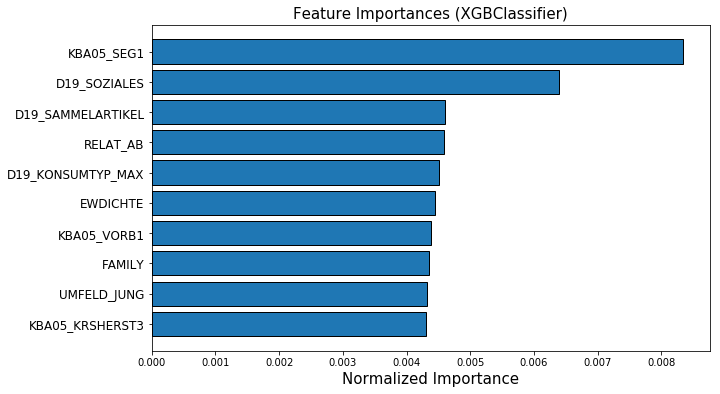

In [305]:
plot_feature_importances(model=bayes_xgb, model_type="XGBClassifier", features=mailout_train_scaled.columns)

#submission 1 lgbm
bayes_lgbm = lgb.LGBMClassifier(application='binary', 
                                boosting_type='gbdt', 
                                class_weight=None,
                                colsample_bytree=1.0, 
                                importance_type='split',
                                learning_rate=0.09531171453332088, 
                                max_bin=100, 
                                max_depth=2,
                                metric='auc', 
                                min_child_samples=14, 
                                min_child_weight=0.001,
                                min_data_in_leaf=265, 
                                min_split_gain=0.0, 
                                n_estimators=24,
                                n_jobs=-1, 
                                num_leaves=450, 
                                objective=None, 
                                random_state=None,
                                reg_alpha=1e-09, 
                                reg_lambda=1.0,
                                scale_pos_weight=69.87642288579819, 
                                silent=True, 
                                subsample=1.0,
                                subsample_for_bin=200000, 
                                subsample_freq=0, 
                                verbose=0)

In [306]:
#submission 2 lgbm
bayes_lgbm = lgb.LGBMClassifier(application='binary', 
                                boosting_type='gbdt', 
                                class_weight=None,
                                colsample_bytree=1.0, 
                                importance_type='split',
                                learning_rate=0.0882410095694084, 
                                max_bin=826, 
                                max_depth=2,
                                metric='auc', 
                                min_child_samples=0, 
                                min_child_weight=0.001,
                                min_data_in_leaf=32, 
                                min_split_gain=0.0, 
                                n_estimators=24,
                                n_jobs=-1, 
                                num_leaves=94, 
                                objective=None, 
                                random_state=None,
                                reg_alpha=1.0, 
                                reg_lambda=1e-09,
                                scale_pos_weight=90.0, 
                                silent=True, 
                                subsample=1.0,
                                subsample_for_bin=200000, 
                                subsample_freq=0, 
                                verbose=0)

In [307]:
bayes_lgbm.fit(mailout_train_scaled, target)

LGBMClassifier(application='binary', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split',
        learning_rate=0.0882410095694084, max_bin=826, max_depth=2,
        metric='auc', min_child_samples=0, min_child_weight=0.001,
        min_data_in_leaf=32, min_split_gain=0.0, n_estimators=24,
        n_jobs=-1, num_leaves=94, objective=None, random_state=None,
        reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=90.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0, verbose=0)

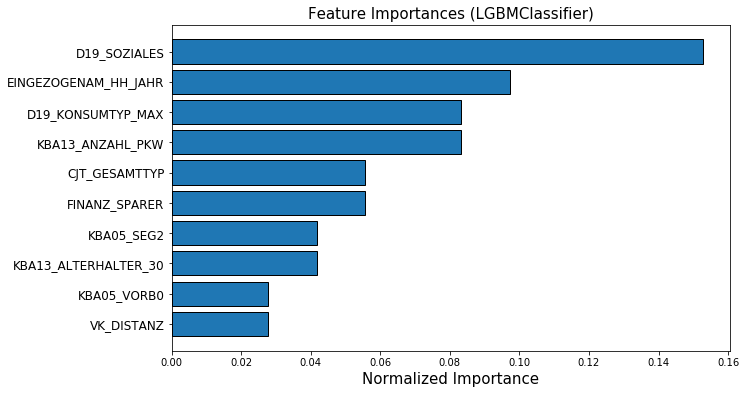

In [308]:
plot_feature_importances(model=bayes_lgbm, model_type="LGBMClassifier", features=mailout_train_scaled.columns)

In [309]:
#plot_comparison_feature(column = 'D19_SOZIALES', df=mailout_train)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
#fit and predict xgb
bayes_xgb.fit(mailout_train_scaled, target)
predictions = bayes_xgb.predict_proba(mailout_test_scaled)[:,1]

In [157]:
#fit and predict lgbm
#bayes_lgbm.fit(mailout_train_scaled, target)
#predictions = bayes_lgbm.predict_proba(mailout_test_scaled)[:,1]

In [ ]:
# create submission file
lnr = pd.DataFrame(mailout_test['LNR'].astype('int32'))
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0: "RESPONSE"})
dfs = [lnr, predictions]
submission = pd.concat(dfs, sort=False, axis=1)
submission.set_index('LNR', inplace = True)
submission.head()

In [311]:
submission.shape

(42833, 1)

In [312]:
submission.to_csv('kaggle_ap_subm.csv')
